In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D, StarDist2D
from csbdeep.utils import Path, normalize
from tifffile import imread
from glob import glob
from tracking_utils import plot_img_label, random_fliprot, random_intensity_change, augmenter
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR) # this goes *before* tf import
import tensorflow as tf
np.random.seed(42)
lbl_cmap = random_label_cmap()
from tracking_utils import *
import trackpy as tp
import pandas as pd
%matplotlib ipympl
import scipy
import sklearn

def detect_features_from_imgs(imgs, frames, model, model_name):
    feature_properties_dict = {'frame':[], 'centroid-1':[], 'centroid-0':[], 'area':[], 'r':[], 'eccentricity':[],\
                                'prob':[], 'area_bbox':[], 'area_convex':[], 'area_filled':[], 'axis_major_length':[],\
                                'axis_minor_length':[], 'bbox-0':[], 'bbox-1':[], 'bbox-2':[], 'bbox-3':[],\
                                'equivalent_diameter_area':[], 'euler_number':[], 'extent':[], 'feret_diameter_max':[],\
                                'inertia_tensor-0-0':[], 'inertia_tensor-0-1':[], 'inertia_tensor-1-0':[],\
                                'inertia_tensor-1-1':[], 'inertia_tensor_eigvals-0':[], 'inertia_tensor_eigvals-1':[],\
                                'label':[]}

    for frame in tqdm(frames):
        img = imgs[frame]
        feature_properties_dict = detect_features_frame(feature_properties_dict, frame, img, model)
                
    feature_properties_dict['r'] = np.sqrt(np.array(feature_properties_dict['area'])/np.pi)
    raw_detection_df = pd.DataFrame(feature_properties_dict)
    raw_detection_df.rename(columns={'centroid-0': 'y', 'centroid-1': 'x'}, inplace=True)
    raw_detection_df['frame'] = raw_detection_df.frame.astype('int')
    raw_detection_df.sort_values(by=['frame', 'prob'], ascending=[True, False], inplace=True)
    return raw_detection_df

In [2]:
run_detection_verb = False
run_linking_verb = False

In [44]:
fps = 100
simulated_trajectories = pd.read_parquet(f'./simulation/simulated_trajectories_{fps}_fps.parquet')
simulated_trajectories['particle'] = simulated_trajectories['label']
# offset the simulated trajectories to the center of the image
simulated_trajectories.loc[:, ['x','y']] = simulated_trajectories.loc[:, ['x','y']] + 250

frames = simulated_trajectories.frame.unique()
imgs = []
masks = []
for frame in tqdm(frames):
    imgs.append(imread(f'./simulation/synthetic_dataset_{fps}_fps/image/synthetic_{frame}.tif'))
    masks.append(imread(f'./simulation/synthetic_dataset_{fps}_fps/mask/synthetic_{frame}.tif'))

if run_detection_verb:
    #model_name = 'stardist_trained'          # stardist model trained for 50 epochs on simulated synthetic dataset
    model_name = 'modified_2D_versatile_fluo' # stardist model trained for 150 epochs on simulated dataset starting from the pretrained 2D versatile fluo model
    model = StarDist2D(None, name = model_name, basedir = './models/')


    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(imgs[0], cmap='gray', vmin = 0, vmax = 255)
    ax[1].imshow(masks[0], cmap=lbl_cmap)
    plt.show()

    raw_detection_df = detect_features_from_imgs(imgs, frames, model, model_name)
    raw_detection_df.to_parquet(f'./simulation/simulated_video_raw_detection_{fps}_fps.parquet')

  0%|          | 0/100000 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/Users/matteoscandola/MasterThesis/tracking/simulation/synthetic_dataset_100_fps/image/synthetic_0.tif'

In [4]:
if run_linking_verb:
    print('Linking stardist_trajectories...')
    cutoff = 100
    t = tp.link_df(raw_detection_df, cutoff, memory = 1, link_strategy = 'hybrid', neighbor_strategy = 'KDTree', adaptive_stop = 1)
    #print(t)
    t = t.sort_values(['frame', 'particle'])
    stardist_trajectories = t#tp.filter_stubs(t, 25)
    # CREATE COLOR COLUMN AND SAVE DF
    n = max(stardist_trajectories.particle)
    print(f'N of droplets: {n + 1}')
    random.seed(5)
    colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]
    for i in range(max(stardist_trajectories.particle)+1-n):
        colors.append('#00FFFF')
    c = []
    for p in t.particle:
        c.append(colors[p])
    stardist_trajectories['color'] = c
    stardist_trajectories = stardist_trajectories.reset_index(drop=True)
    stardist_trajectories.to_parquet(f'./simulation/simulated_video_linked_detection_{fps}_fps.parquet')
else:
    stardist_trajectories = pd.read_parquet(f'./simulation/simulated_video_linked_detection_{fps}_fps.parquet')

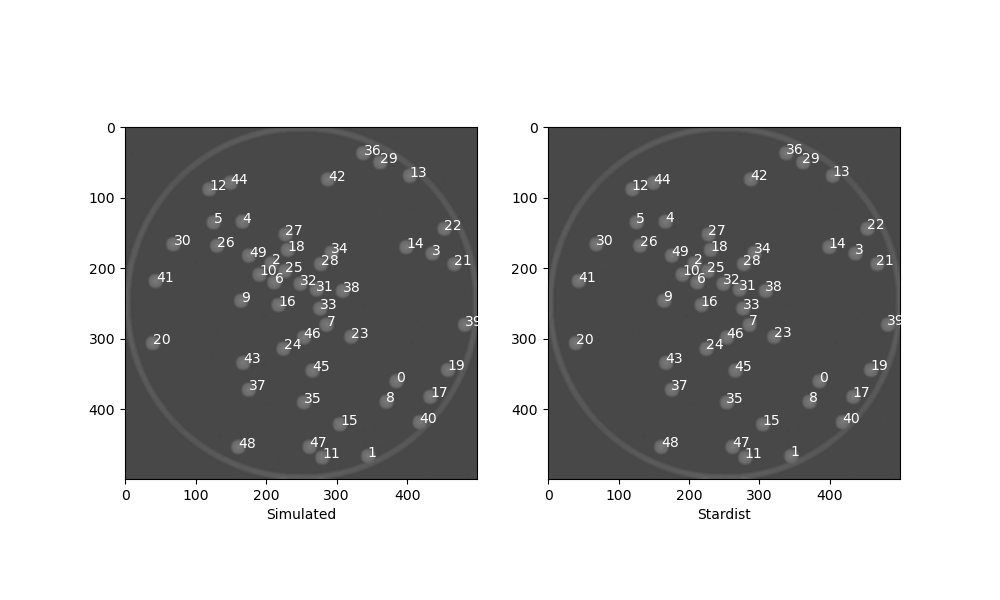

In [5]:
# match simulated and stardist trajectories particle ids
dist_matrix = scipy.spatial.distance_matrix(stardist_trajectories.loc[stardist_trajectories.frame == 0 ,['x','y']], simulated_trajectories.loc[simulated_trajectories.frame == 0, ['x','y']])                                    
id_assignment = scipy.optimize.linear_sum_assignment(dist_matrix)
stardist_trajectories['particle'] = np.array([id_assignment[1] for i in range(len(frames))]).flatten()
stardist_trajectories = stardist_trajectories.sort_values(['frame', 'particle'])
simulated_trajectories = simulated_trajectories.sort_values(['frame', 'particle'])

df1 = simulated_trajectories.loc[simulated_trajectories.frame == 0]
df2 = stardist_trajectories.loc[stardist_trajectories.frame == 0]
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 6))
ax.imshow(imgs[0], cmap='gray', vmin = 0, vmax = 255)
for i in range(len(df1)):
    ax.text(df1.iloc[i].x, df1.iloc[i].y, str(int(df1.iloc[i].particle)), color = 'w')
ax.set(xlabel = 'Simulated')
ax1.imshow(imgs[0], cmap='gray', vmin = 0, vmax = 255)
for i in range(len(df2)):
    ax1.text(df2.iloc[i].x, df2.iloc[i].y, str(df2.iloc[i].particle), color = 'w')
ax1.set(xlabel = 'Stardist')
plt.show()

In [6]:
import yupi.stats as ys
from yupi import Trajectory, WindowType, DiffMethod
def get_trajs(nDrops, trajs, fps, subsample_factor):
    Trajs = []
    for i in range(0, nDrops):
        p = trajs.loc[trajs.particle == i, ['x','y']][::subsample_factor]
        Trajs.append(Trajectory(p.x, p.y, dt = 1/fps*subsample_factor, traj_id=i, diff_est={'method':DiffMethod.LINEAR_DIFF, 
                                                                                  'window_type': WindowType.CENTRAL}))
    return Trajs

In [7]:
turn_angles_bins = np.linspace(-np.pi, np.pi, 101)
speed_bins = np.arange(0, 100, .2)

In [42]:
subsample = False
if subsample:
    simulated_trajectories2 = simulated_trajectories.loc[simulated_trajectories.frame.isin(simulated_trajectories.frame.unique()[::3])]
    stardist_trajectories2 = stardist_trajectories.loc[stardist_trajectories.frame.isin(stardist_trajectories.frame.unique()[::3])]
else:
    simulated_trajectories2 = simulated_trajectories
    stardist_trajectories2 = stardist_trajectories

In [37]:
for polyorder in range(2, 10):
    windList = np.append(0, np.arange(polyorder + 1, 50, 1))
    MSE = np.zeros(len(windList))
    MSE_turn_angles = np.zeros(len(windList))
    MSE_speed = np.zeros(len(windList))

    simulated_positions = simulated_trajectories2.loc[:, ['x', 'y']].values.reshape(len(simulated_trajectories2.frame.unique()), 50, 2)
    stardist_positions = stardist_trajectories2.loc[:, ['x', 'y']].values.reshape(len(stardist_trajectories2.frame.unique()), 50, 2) 
    MSE[0] = np.mean((simulated_positions - stardist_positions)**2)

    simulation_turning_angles = ys.turning_angles_ensemble(get_trajs(50, simulated_trajectories2, 30, 1), centered = True)
    simulation_turning_angles_counts, _ = np.histogram(simulation_turning_angles, bins = turn_angles_bins, density = True)
    stardist_turning_angles = ys.turning_angles_ensemble(get_trajs(50, stardist_trajectories2, 30, 1), centered = True)
    stardist_turning_angles_counts, _ = np.histogram(stardist_turning_angles, bins = turn_angles_bins, density = True)
    MSE_turn_angles[0] = np.mean((simulation_turning_angles_counts - stardist_turning_angles_counts)**2)

    simulation_speed = ys.speed_ensemble(get_trajs(50, simulated_trajectories2, 30, 1), step=1)
    simulation_speed_counts, _ = np.histogram(simulation_speed, bins = speed_bins, density = True)
    stardist_speed = ys.speed_ensemble(get_trajs(50, stardist_trajectories2, 30, 1), step=1)
    stardist_speed_counts, _ = np.histogram(stardist_speed, bins = speed_bins, density = True)
    MSE_speed[0] = np.mean((simulation_speed_counts - stardist_speed_counts)**2)

    i = 1
    for wind in tqdm(windList[1:]):
        stardist_smooth_trajs = get_smooth_trajs(stardist_trajectories2, wind, polyorder)
        smoooth_stardist_positions = stardist_smooth_trajs.loc[:, ['x', 'y']].values.reshape(len(stardist_smooth_trajs.frame.unique()), 50, 2)
        MSE[i] = np.mean((simulated_positions - smoooth_stardist_positions)**2)
        
        smooth_stardist_turning_angles = ys.turning_angles_ensemble(get_trajs(50, stardist_smooth_trajs, 30, 1), centered= True)
        smooth_stardistis_turning_angles_counts, _ = np.histogram(smooth_stardist_turning_angles, bins = turn_angles_bins, density = True)
        MSE_turn_angles[i] = np.mean((simulation_turning_angles_counts - smooth_stardistis_turning_angles_counts)**2)

        smooth_stardist_speed = ys.speed_ensemble(get_trajs(50, stardist_smooth_trajs, 30, 1), step=1)
        smooth_stardistis_speed_counts, _ = np.histogram(smooth_stardist_speed, bins = speed_bins, density = True)

        MSE_speed[i] = np.mean((simulation_speed_counts - smooth_stardistis_speed_counts)**2)
        i += 1

    fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize = (14, 5))
    ax.plot(windList, MSE_turn_angles)
    ax.set(xlabel = 'Window size', ylabel = 'MSE', title = 'MSE of turning angles')
    ax.grid()
    ax1.plot(windList, MSE)
    ax1.set(xlabel = 'Window size', ylabel = 'MSE', title = 'MSE of positions')
    ax1.grid()
    ax1.set(ylim = (0, 1))
    ax2.plot(windList, MSE_speed)
    ax2.set(xlabel = 'Window size', ylabel = 'MSE', title = 'MSE of speed')
    ax2.grid()
    plt.suptitle(f'MSE of stardist smoothet with polynomial order: {polyorder}')
    plt.tight_layout()
    if subsample:
        plt.savefig(f'./simulation/smoothing_analysis_{fps}_fps_3_subsample/stardist_smoothed_MSE_polyorder_{polyorder}.png')
    else:
        plt.savefig(f'./simulation/smoothing_analysis_{fps}_fps/stardist_smoothed_MSE_polyorder_{polyorder}.png')
    plt.close()

100%|██████████| 40/40 [00:06<00:00,  6.16it/s]


14:51:58 [WARNING] No such comm: 6fd2aa71d7c04e7e9360bb166df1ae72
14:51:58 [WARNING] No such comm: 6fd2aa71d7c04e7e9360bb166df1ae72
14:51:58 [WARNING] No such comm: 6fd2aa71d7c04e7e9360bb166df1ae72
14:51:58 [WARNING] No such comm: 6fd2aa71d7c04e7e9360bb166df1ae72
14:51:58 [WARNING] No such comm: 6fd2aa71d7c04e7e9360bb166df1ae72
14:52:00 [WARNING] No such comm: 6fd2aa71d7c04e7e9360bb166df1ae72


In [48]:
simulation_turning_angles = ys.turning_angles_ensemble(get_trajs(50, simulated_trajectories, 30, 1), centered = True)
simulation_turning_angles_counts, _ = np.histogram(simulation_turning_angles, bins = turn_angles_bins, density = True)
simulation_speed = ys.speed_ensemble(get_trajs(50, simulated_trajectories, 30, 1), step=1)
simulation_speed_counts, _ = np.histogram(simulation_speed, bins = speed_bins, density = True)

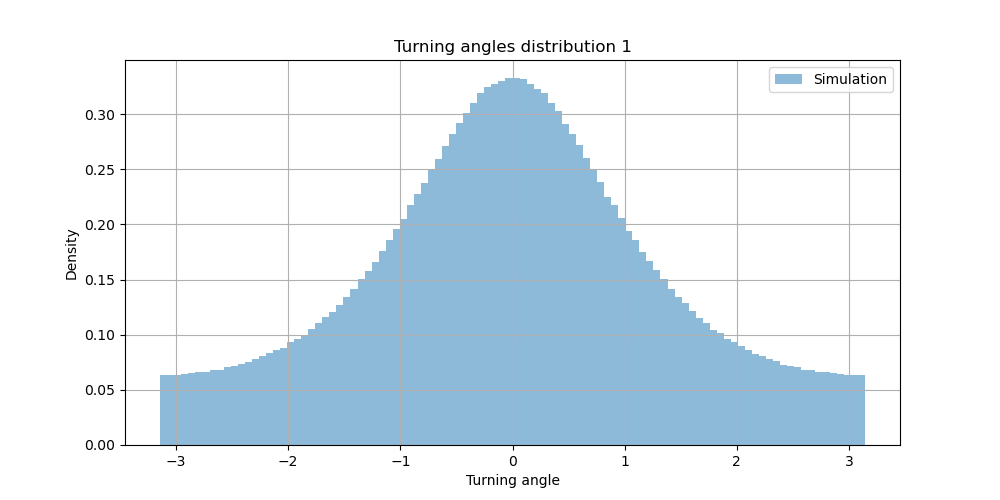

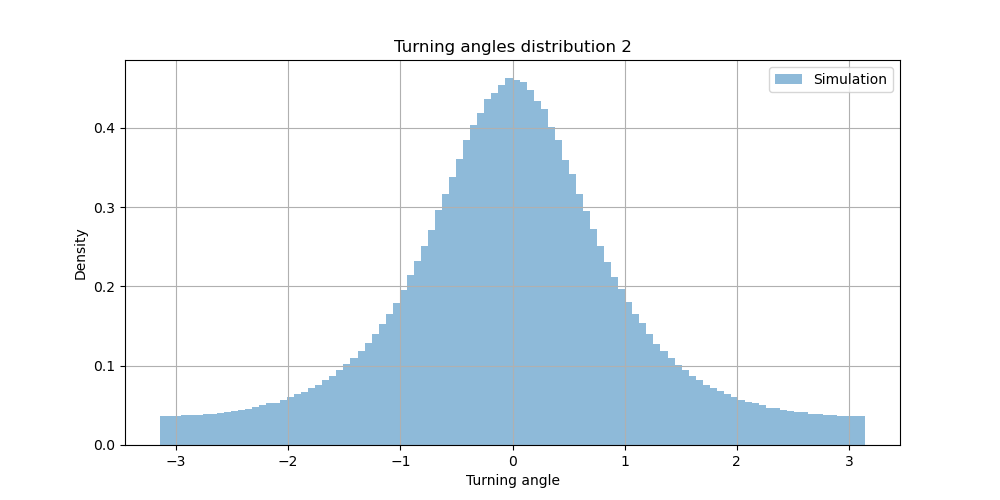

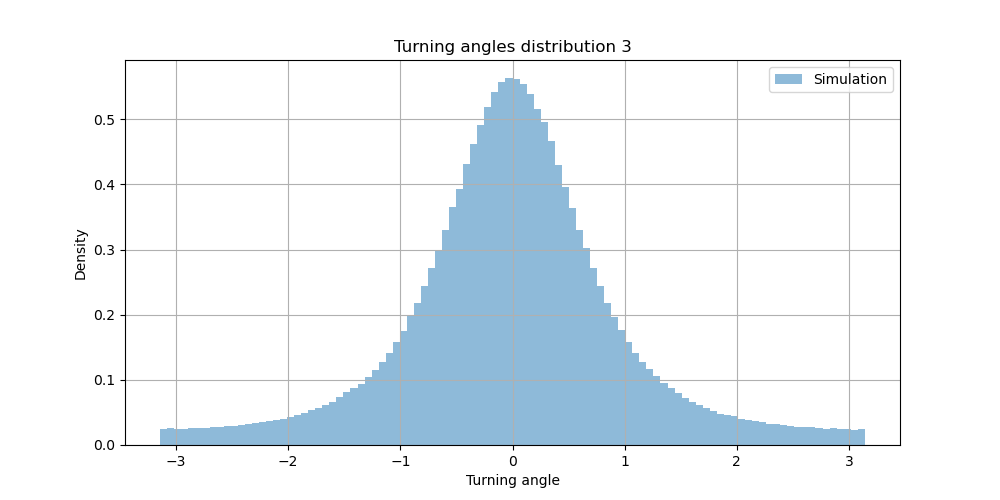

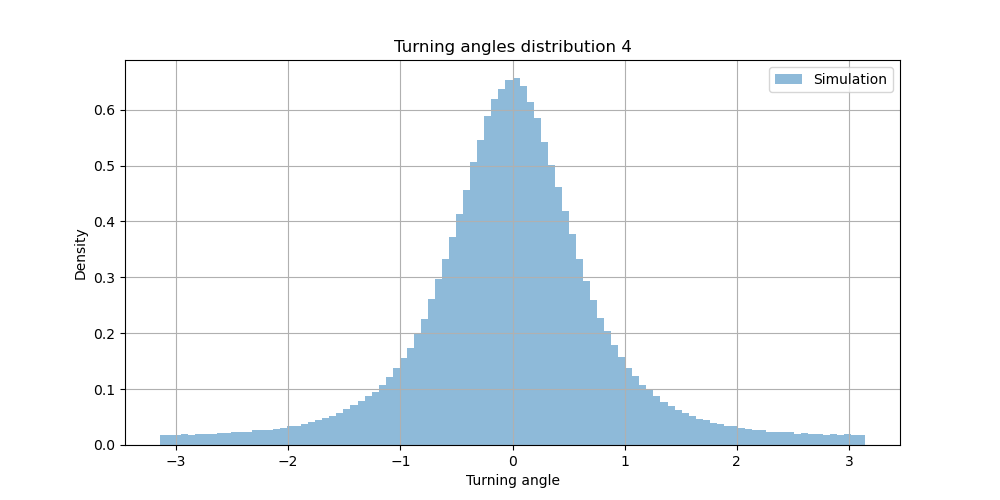

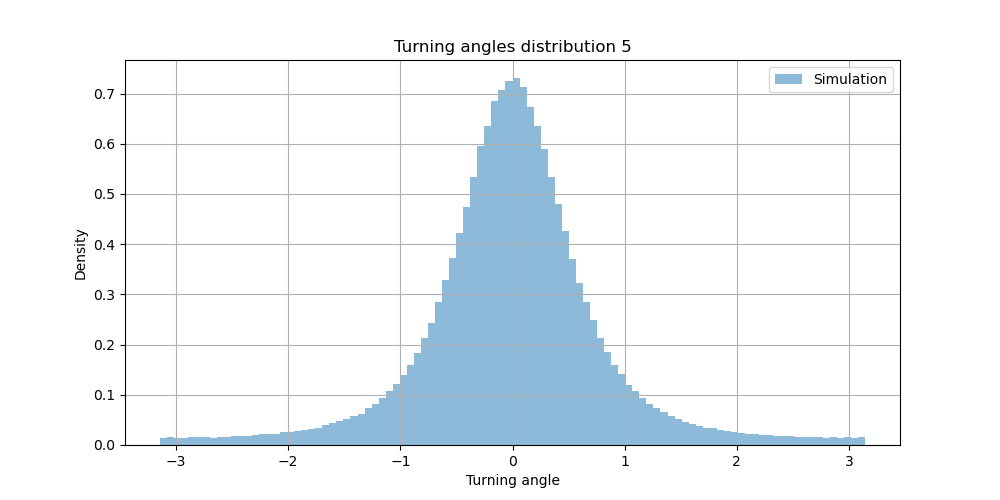

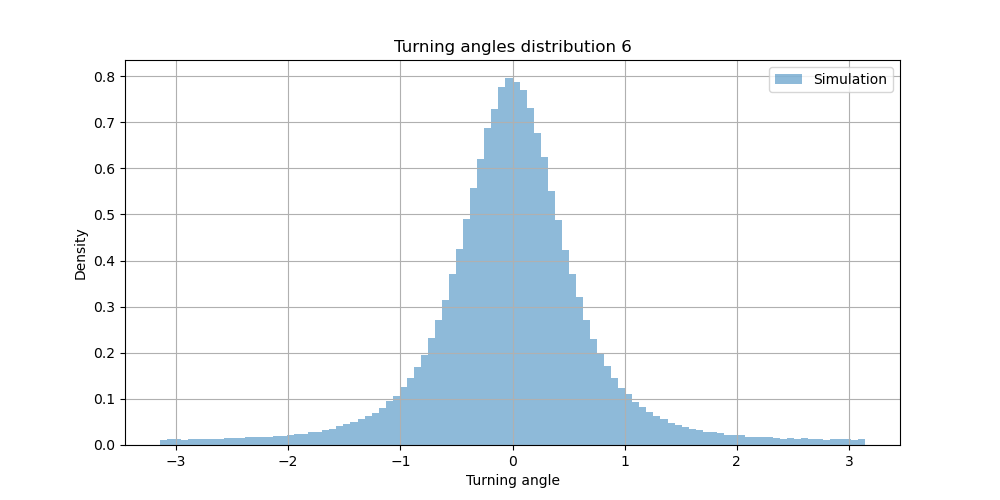

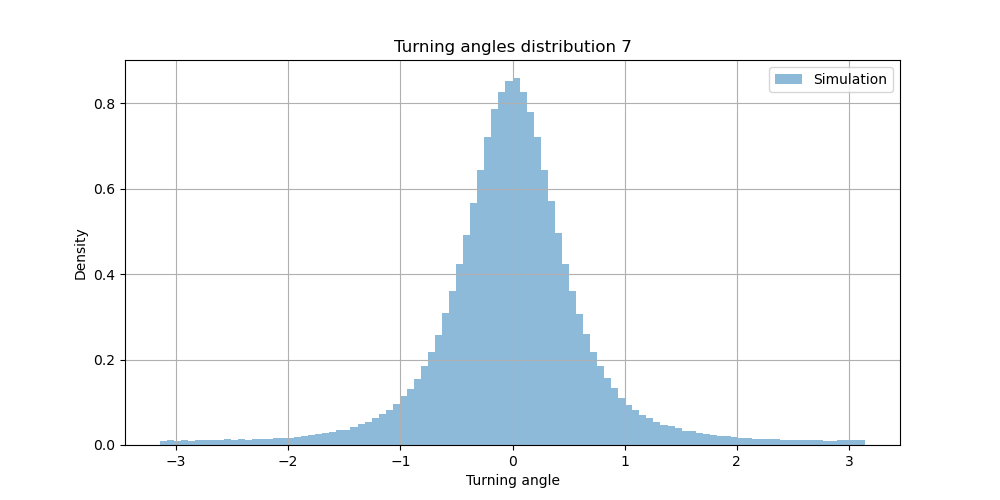

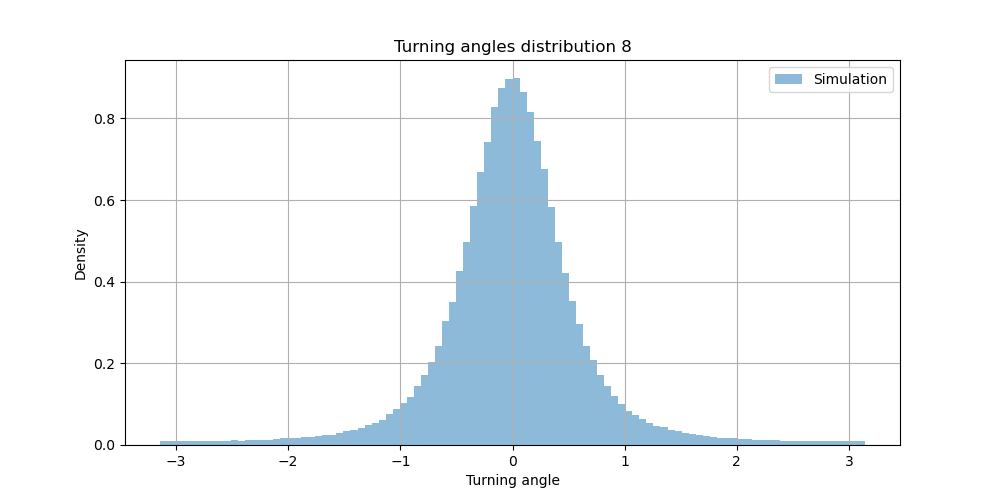

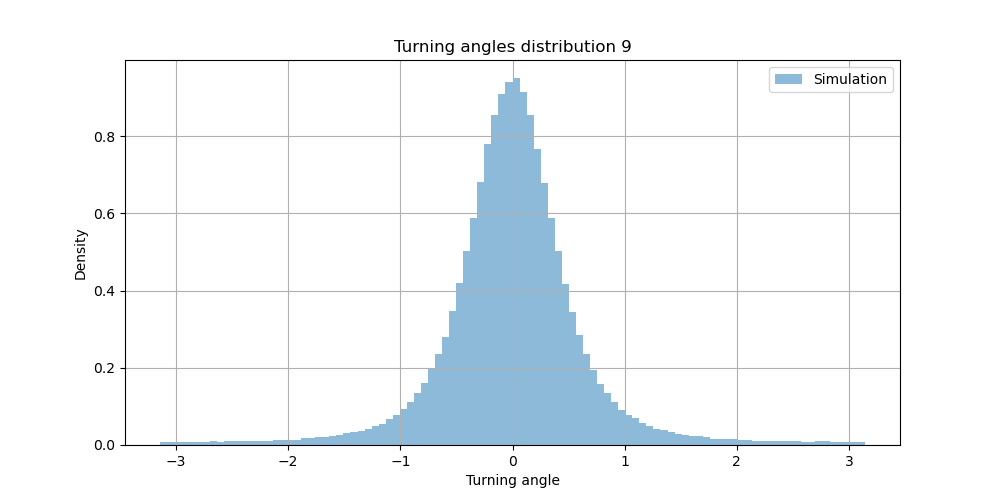

In [56]:
for i in range(1,10):
    simulated_trajectories2 = simulated_trajectories.loc[simulated_trajectories.frame.isin(simulated_trajectories.frame.unique()[::i])]
    simulation_turning_angles = ys.turning_angles_ensemble(get_trajs(50, simulated_trajectories2, 30, 1), centered = True)
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.hist(simulation_turning_angles, bins = turn_angles_bins, density = True, alpha = .5, label = 'Simulation')
    ax.set(title = f'Turning angles distribution {i}', xlabel = 'Turning angle', ylabel = 'Density')
    ax.legend()
    ax.grid()
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './simulation/smoothing_analysis_100_fps/stardist_smoothed_trajectories.png'

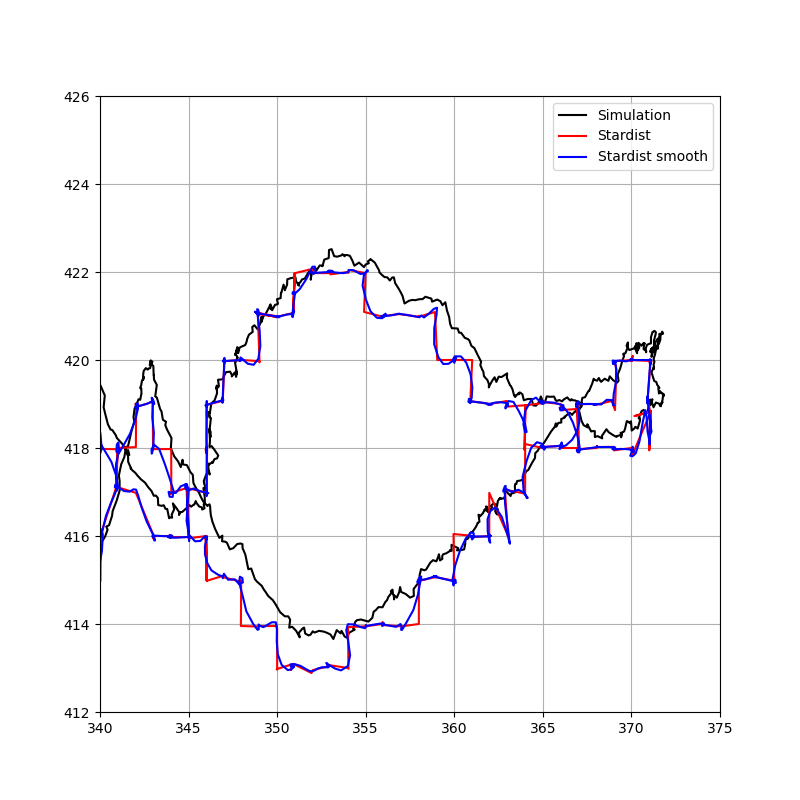

In [45]:
if subsample:
    stardist_smooth_trajs = get_smooth_trajs(stardist_trajectories2, windLen = 10, orderofPoly = 4)
else:
    stardist_smooth_trajs = get_smooth_trajs(stardist_trajectories2, windLen = 15, orderofPoly = 6)
smooth_stardist_speed = ys.speed_ensemble(get_trajs(50, stardist_smooth_trajs, 30, 1), step=1)
smooth_stardist_turning_angles = ys.turning_angles_ensemble(get_trajs(50, stardist_smooth_trajs, 30, 1), centered = True)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(simulated_trajectories2.loc[simulated_trajectories2.particle == 0].x, simulated_trajectories2.loc[simulated_trajectories2.particle == 0].y, color = 'k', label = 'Simulation')
ax.plot(stardist_trajectories2.loc[stardist_trajectories2.particle == 0].x, stardist_trajectories2.loc[stardist_trajectories2.particle == 0].y, color = 'r', label = 'Stardist')
ax.plot(stardist_smooth_trajs.loc[stardist_smooth_trajs.particle == 0].x, stardist_smooth_trajs.loc[stardist_smooth_trajs.particle == 0].y, label = 'Stardist smooth', color = 'b')
ax.legend()
ax.grid()
ax.set(xlim=(340, 375), ylim = (412, 426))
if subsample:
    plt.savefig(f'./simulation/smoothing_analysis_{fps}_fps_3_subsample/stardist_smoothed_trajectory_example.png')
else:
    plt.savefig(f'./simulation/smoothing_analysis_{fps}_fps/stardist_smoothed_trajectories.png')
plt.show()

fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 4), sharex=True, sharey=True)
ax.hist(stardist_turning_angles, bins = turn_angles_bins, density = True, alpha = 0.5, label = 'Stardist', color = 'r')
ax1.hist(smooth_stardist_turning_angles, bins = turn_angles_bins, density = True, alpha = 0.5, label = 'Stardist smooth', color = 'b')
ax2.hist(simulation_turning_angles, bins = turn_angles_bins, density = True, alpha = 0.5, label = 'Simulation', color = 'k')
ax.set(xlabel = 'Turning angle', ylabel = 'pdf')
ax1.set(xlabel = 'Turning angle', ylabel = 'pdf')
ax2.set(xlabel = 'Turning angle', ylabel = 'pdf')
ax.legend()
ax1.legend()
ax2.legend()
if subsample:
    plt.savefig(f'./simulation/smoothing_analysis_{fps}_fps_3_subsample/stardist_smoothed_turning_angles.png')
else:
    plt.savefig(f'./simulation/smoothing_analysis_{fps}_fps/stardist_smoothed_turning_angles.png')
plt.show()

fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
ax.hist(stardist_speed, bins = speed_bins, density = True, alpha = 0.5, label = 'Stardist', color = 'r')
ax1.hist(smooth_stardist_speed, bins = speed_bins, density = True, alpha = 0.5, label = 'Stardist smooth', color = 'b')
ax2.hist(simulation_speed, bins = speed_bins, density = True, alpha = 0.5, label = 'Simulation', color = 'k')
ax.set(xlabel = 'Speed', ylabel = 'pdf')
ax1.set(xlabel = 'Speed', ylabel = 'pdf')
ax2.set(xlabel = 'Speed', ylabel = 'pdf')
ax.legend()
ax1.legend()
ax2.legend()
if subsample:
    plt.savefig(f'./simulation/smoothing_analysis_{fps}_fps_3_subsample/stardist_smoothed_speed.png')
else:
    plt.savefig(f'./simulation/smoothing_analysis_{fps}_fps/stardist_smoothed_speed.png')
plt.show()

In [11]:
# Histogram fit
def fit_hist(y, bins_, distribution, p0_):
    bins_c = bins_[:-1] + np.diff(bins_) / 2
    bin_heights, _ = np.histogram(y, bins = bins_, density = True)
    ret, pcov = curve_fit(distribution, bins_c, bin_heights, p0 = p0_, maxfev = 1000)
    ret_std = np.sqrt(np.diag(pcov))
    return ret, ret_std

# 2D Maxwell-Boltzmann distribution
def MB_2D(v, sigma):
    return v/(sigma**2) * np.exp(-v**2/(2*sigma**2))


# Generalized 2D Maxwell-Boltzmann distribution
def MB_2D_generalized(v, sigma, beta, A):
    return A*v * np.exp(-v**beta/(2*sigma**beta))


# Normal distribution
def normal_distr(x, sigma, mu):
    return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*((x-mu)/sigma)**2)


# Lorentzian distribution
def lorentzian_distr(x, gamma, x0):
    return 1/np.pi * gamma / ((x-x0)**2 + gamma**2)

In [14]:
from scipy.optimize import curve_fit

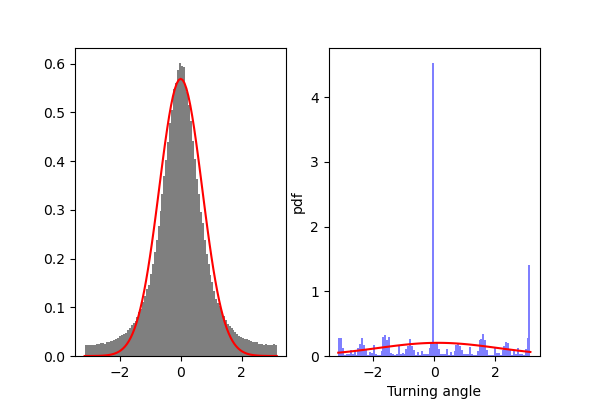

In [16]:
simulation_turning_angles = ys.turning_angles_ensemble(get_trajs(50, simulated_trajectories2, 30, 1), centered = True)
stardist_turning_angles = ys.turning_angles_ensemble(get_trajs(50, stardist_trajectories2, 30, 1), centered = True)

a, b = fit_hist(simulation_turning_angles, turn_angles_bins, normal_distr, [1., 0.])
c, d = fit_hist(stardist_turning_angles, turn_angles_bins, normal_distr, [1., 0.])

fig, (ax,ax1) = plt.subplots(1, 2, figsize=(6, 4))
ax.hist(simulation_turning_angles, bins = turn_angles_bins, density = True, alpha = 0.5, label = 'Simulation', color = 'k')
ax.plot(turn_angles_bins, normal_distr(turn_angles_bins, *a), label = 'Normal fit', color = 'r')
ax1.hist(stardist_turning_angles, bins = turn_angles_bins, density = True, alpha = 0.5, label = 'Stardist', color = 'b')
ax1.plot(turn_angles_bins, normal_distr(turn_angles_bins, *c), color = 'r')
ax1.set(xlabel = 'Turning angle', ylabel = 'pdf')
plt.show()

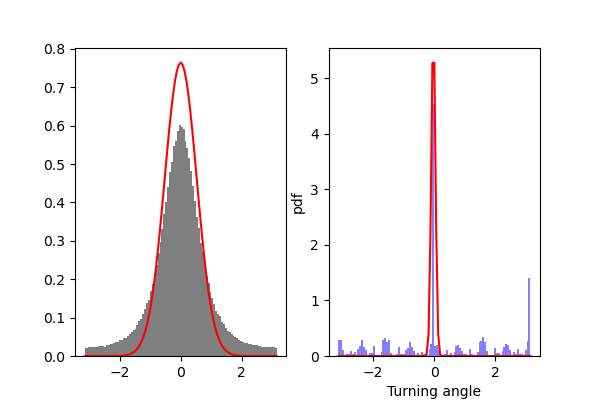

In [17]:
simulation_turning_angles = ys.turning_angles_ensemble(get_trajs(50, simulated_trajectories2, 30, 1), centered = True)
stardist_turning_angles = ys.turning_angles_ensemble(get_trajs(50, stardist_trajectories2, 30, 1), centered = True)

a, b = fit_hist(simulation_turning_angles, turn_angles_bins, lorentzian_distr, [1., 0.])
c, d = fit_hist(stardist_turning_angles, turn_angles_bins, lorentzian_distr, [1., 0.])

fig, (ax,ax1) = plt.subplots(1, 2, figsize=(6, 4))
ax.hist(simulation_turning_angles, bins = turn_angles_bins, density = True, alpha = 0.5, label = 'Simulation', color = 'k')
ax.plot(turn_angles_bins, normal_distr(turn_angles_bins, *a), label = 'Normal fit', color = 'r')
ax1.hist(stardist_turning_angles, bins = turn_angles_bins, density = True, alpha = 0.5, label = 'Stardist', color = 'b')
ax1.plot(turn_angles_bins, normal_distr(turn_angles_bins, *c), color = 'r')
ax1.set(xlabel = 'Turning angle', ylabel = 'pdf')
plt.show()

0.1579306722903855 31.781589855215103 1
0.10179346050773752 21.073419772507894 1


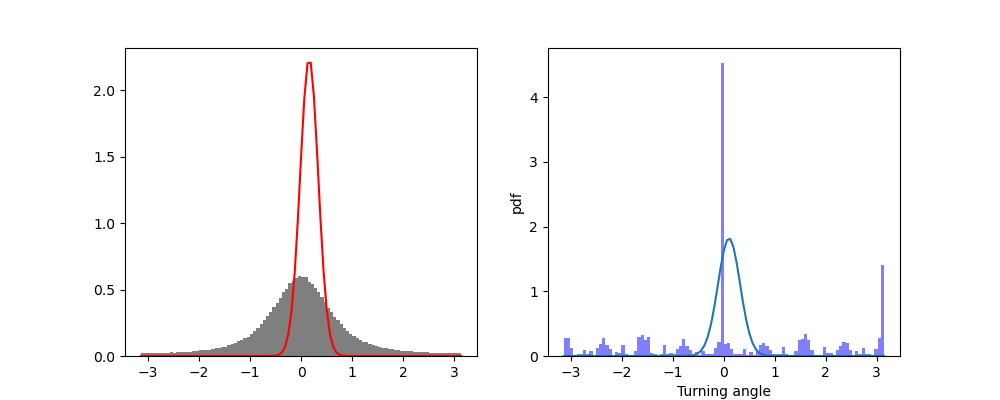

In [29]:
from scipy.stats import vonmises

simulation_turning_angles = ys.turning_angles_ensemble(get_trajs(50, simulated_trajectories2, 30, 1), centered = True)
simulation_turning_angles_counts, _ = np.histogram(simulation_turning_angles, bins = turn_angles_bins, density = True)
stardist_turning_angles = ys.turning_angles_ensemble(get_trajs(50, stardist_trajectories2, 30, 1), centered = True)
stardist_turning_angles_counts, _ = np.histogram(stardist_turning_angles, bins = turn_angles_bins, density = True)

kappa1, loc1, scale1 = vonmises.fit(simulation_turning_angles_counts, loc = 0)
print(loc1, kappa1, scale1)
kappa2, loc2, scale2 = vonmises.fit(stardist_turning_angles_counts, loc = 0)
print(loc2, kappa2, scale2)

fig, (ax,ax1) = plt.subplots(1, 2, figsize=(10, 4))
ax.hist(simulation_turning_angles, bins = turn_angles_bins, density = True, alpha = 0.5, label = 'Simulation', color = 'k')
ax.plot(turn_angles_bins, vonmises.pdf(loc1, kappa1, turn_angles_bins), label = 'vonmises fit', color = 'r')
ax1.hist(stardist_turning_angles, bins = turn_angles_bins, density = True, alpha = 0.5, label = 'Stardist', color = 'b')
ax1.plot(turn_angles_bins, vonmises.pdf(loc2, kappa2, turn_angles_bins))
ax1.set(xlabel = 'Turning angle', ylabel = 'pdf')
plt.show()